Notebook for training a 3D U-Net for vestibular schwannoma segmentation.

In [ ]:
# This cell is for Colab runs

!pip install tensorflow==2.10.1  # same version of tf used in local testing, Colab default (2.13) gives import errors with segmentation models library

!pip install segmentation_models_3D

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split, KFold
import tensorflow as tf
import pandas as pd
import segmentation_models_3D as sm
import att_res_unet

Segmentation Models: using `tf.keras` framework.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


In [3]:
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_DEPTH = 64
IMG_CHANNELS = 1
SEED = 42
random.seed(SEED)

Connect to Drive if running on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Load the data.

In [4]:
#Colab data paths
# mris_path = "/content/drive/MyDrive/bsc_thesis_data_t1_numpy/mris_dataset.npy"
# masks_path = "/content/drive/MyDrive/bsc_thesis_data_t1_numpy/masks_dataset.npy"

# Paths on local machine
mris_path = r"C:\Users\joona\Documents\LUT\bsc_thesis\bsc_thesis_data_t1_numpy\mris_dataset_64.npy"
masks_path = r"C:\Users\joona\Documents\LUT\bsc_thesis\bsc_thesis_data_t1_numpy\masks_dataset_64.npy"

mris = np.load(mris_path)
masks = np.load(masks_path)



In [5]:
mris.shape

(242, 64, 64, 64)

In [6]:
masks.shape

(242, 64, 64, 64)

Normalise the data.

In [7]:
# def normalize_3d_image(img):
#     return (img - img.min()) / (img.max() - img.min())


def standardize_3d_image(img):
    """
    Standardize a 3D image using Z-score normalization.

    Parameters:
    - img: 3D numpy array representing the MRI image.

    Returns:
    - standardized_img: 3D numpy array representing the standardized MRI image.
    """
    mean = np.mean(img)
    std = np.std(img)
    standardized_img = (img - mean) / std
    return standardized_img

Normalise the data and print out the min and max pixel intensities before and after.

In [8]:
print(np.min(mris))
print(np.max(mris))

-195.05598
4172.222


In [9]:
for i in range(mris.shape[0]):
    mris[i] = standardize_3d_image(mris[i])

In [10]:
print(np.min(mris))
print(np.max(mris))

-1.4170647
10.592862


In [11]:
# Create an array of indices corresponding to the original dataset
indices = np.arange(len(mris))

X_train, X_test, Y_train, Y_test, train_indices, test_indices = train_test_split(
    mris, masks, indices, test_size=0.20, shuffle=True, random_state=SEED
)

Function for building the model using segmentation models library.

In [12]:
def build():

  model = sm.Unet(
      "resnet34",
      input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH, IMG_CHANNELS),
      encoder_weights=None,
      activation="sigmoid",
  )


  dice_loss = sm.losses.DiceLoss()
  bce_loss = sm.losses.BinaryCELoss()
  total_loss = dice_loss + bce_loss


  initial_learning_rate = 0.001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
  )
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=total_loss,
      metrics=[sm.metrics.IOUScore()],
  )
  return model

Initialise the k-fold cross validation and lists to store evaluation metrics.

In [13]:
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)

#indices = np.arange(len(mris)) # Array for patient indices for retracing patients after cross-validation shuffle. 
train_dice_list = []
val_dice_list = []
dataframes = []

In [14]:
def build_dfs(test_ids, dice_scores):
    data = {
        "Patient Indices": test_ids,
        "Dice": dice_scores
    }
    # Create DataFrame
    df = pd.DataFrame(data)
    # Calculate the average and standard deviation of dice_scores
    avg_dice = np.mean(dice_scores)
    std_dice = np.std(dice_scores)
    
    # add a new row with average and standard deviation
    df = pd.concat([df, pd.DataFrame({"Patient Indices": ["Avg."], "Dice": [f"{avg_dice:.2f}"]})], ignore_index=True)
    df = pd.concat([df, pd.DataFrame({"Patient Indices": ["Std."], "Dice": [f"{std_dice:.2f}"]})], ignore_index=True)

    
    return df

Create a function to evaluate the segmentation performance.

In [15]:
def getScore(predictions, test_mask):
    intersection = np.logical_and(test_mask, predictions)
    dice_score = (np.sum(intersection) * 2) / (np.sum(predictions) + np.sum(test_mask))

    return dice_score

Train the model inside the cross-validation loop.

In [16]:
fold = 1
for train_index, val_index in kf.split(X_train, Y_train):
  # Split data
  X_train_fold, X_val = X_train[train_index], X_train[val_index]
  Y_train_fold, Y_val = Y_train[train_index], Y_train[val_index]
  train_ids, val_ids = train_indices[train_index], train_indices[val_index]

  print(
      f"Training data\nDimensions: {X_train_fold.shape}\nMax-value: {np.max(X_train_fold)}\nMin-value: {np.min(X_train_fold)}"
  )
  print(
    f"Test data\nDimensions: {X_val.shape}\nMax-value: {np.max(X_val)}\nMin-value: {np.min(X_val)}"
  )
  #model = build()
  model = att_res_unet.build_unet(input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH,IMG_CHANNELS))  # Try self built model
  
  dice_loss = sm.losses.DiceLoss()
  bce_loss = sm.losses.BinaryCELoss()
  total_loss = dice_loss + bce_loss


  initial_learning_rate = 0.0001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
  )
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=total_loss,
      metrics=[sm.metrics.FScore()],
  )
  
  cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_f1-score", mode="max", patience=15, restore_best_weights=True
  )

  history = model.fit(
    X_train_fold, Y_train_fold, epochs=100, batch_size=2, validation_data=(X_val, Y_val), callbacks= [cb]
  )

  train_dice_list.append(history.history["f1-score"])
  val_dice_list.append(history.history["val_f1-score"])

  # Loop through each item, predict, and calculate scores

  dice_scores = [] # list for containing an individual test folds dice scores

  for i in range(X_val.shape[0]):
      single_item = np.expand_dims(X_val[i], axis=0)
      pred = model.predict(single_item)
      pred_t = (pred > 0.5).squeeze()  #  remove any singleton dimensions
      Y_val_single = Y_val[i]
      dice_score = getScore(pred_t, Y_val_single)

      dice_scores.append(dice_score)
  print(f"Average of validation folds Dice Scores: {np.mean(dice_scores)}")
  dataframes.append(build_dfs(val_ids, dice_scores))
  model.save(r"C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_"+ str(fold))
  fold +=1


Training data
Dimensions: (154, 64, 64, 64)
Max-value: 10.592862129211426
Min-value: -1.4170646667480469
Test data
Dimensions: (39, 64, 64, 64)
Max-value: 9.828779220581055
Min-value: -1.2753536701202393
Epoch 1/100
77/77 [==============================] - 26s 213ms/step - loss: 1.0924 - f1-score: 7.9523e-04 - val_loss: 1.1100 - val_f1-score: 0.0013
Epoch 2/100
77/77 [==============================] - 15s 189ms/step - loss: 0.9986 - f1-score: 0.0055 - val_loss: 1.0124 - val_f1-score: 0.0024
Epoch 3/100
77/77 [==============================] - 15s 190ms/step - loss: 0.4830 - f1-score: 0.5184 - val_loss: 0.7010 - val_f1-score: 0.3075
Epoch 4/100
77/77 [==============================] - 14s 184ms/step - loss: 0.2381 - f1-score: 0.7627 - val_loss: 0.3213 - val_f1-score: 0.6822
Epoch 5/100
77/77 [==============================] - 15s 190ms/step - loss: 0.2105 - f1-score: 0.7902 - val_loss: 0.1874 - val_f1-score: 0.8147
Epoch 6/100
77/77 [==============================] - 14s 181ms/step - lo

INFO:tensorflow:Assets written to: C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_1\assets


INFO:tensorflow:Assets written to: C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_1\assets


Training data
Dimensions: (154, 64, 64, 64)
Max-value: 10.592862129211426
Min-value: -1.4170646667480469
Test data
Dimensions: (39, 64, 64, 64)
Max-value: 10.325362205505371
Min-value: -1.30536687374115
Epoch 1/100
77/77 [==============================] - 17s 195ms/step - loss: 1.1185 - f1-score: 0.0013 - val_loss: 1.2288 - val_f1-score: 9.5327e-04
Epoch 2/100
77/77 [==============================] - 14s 180ms/step - loss: 1.0047 - f1-score: 0.0018 - val_loss: 1.0375 - val_f1-score: 9.5167e-04
Epoch 3/100
77/77 [==============================] - 14s 182ms/step - loss: 1.0018 - f1-score: 0.0030 - val_loss: 1.0069 - val_f1-score: 0.0014
Epoch 4/100
77/77 [==============================] - 14s 181ms/step - loss: 0.9482 - f1-score: 0.0554 - val_loss: 1.0029 - val_f1-score: 0.0012
Epoch 5/100
77/77 [==============================] - 14s 184ms/step - loss: 0.3276 - f1-score: 0.6733 - val_loss: 0.9150 - val_f1-score: 0.0872
Epoch 6/100
77/77 [==============================] - 14s 182ms/step -

INFO:tensorflow:Assets written to: C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_2\assets


INFO:tensorflow:Assets written to: C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_2\assets


Training data
Dimensions: (154, 64, 64, 64)
Max-value: 10.592862129211426
Min-value: -1.3901468515396118
Test data
Dimensions: (39, 64, 64, 64)
Max-value: 9.202779769897461
Min-value: -1.4170646667480469
Epoch 1/100
77/77 [==============================] - 17s 195ms/step - loss: 1.0402 - f1-score: 7.3687e-04 - val_loss: 1.0482 - val_f1-score: 0.0014
Epoch 2/100
77/77 [==============================] - 15s 189ms/step - loss: 0.9419 - f1-score: 0.0623 - val_loss: 1.0025 - val_f1-score: 0.0029
Epoch 3/100
77/77 [==============================] - 14s 185ms/step - loss: 0.3662 - f1-score: 0.6349 - val_loss: 0.8480 - val_f1-score: 0.1519
Epoch 4/100
77/77 [==============================] - 15s 189ms/step - loss: 0.2318 - f1-score: 0.7690 - val_loss: 0.3871 - val_f1-score: 0.6174
Epoch 5/100
77/77 [==============================] - 15s 189ms/step - loss: 0.2075 - f1-score: 0.7932 - val_loss: 0.3765 - val_f1-score: 0.6281
Epoch 6/100
77/77 [==============================] - 15s 190ms/step - lo

INFO:tensorflow:Assets written to: C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_3\assets


INFO:tensorflow:Assets written to: C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_3\assets


Training data
Dimensions: (155, 64, 64, 64)
Max-value: 10.592862129211426
Min-value: -1.4170646667480469
Test data
Dimensions: (38, 64, 64, 64)
Max-value: 9.554264068603516
Min-value: -1.3901468515396118
Epoch 1/100
78/78 [==============================] - 18s 201ms/step - loss: 1.0513 - f1-score: 8.5341e-04 - val_loss: 1.0879 - val_f1-score: 0.0014
Epoch 2/100
78/78 [==============================] - 15s 187ms/step - loss: 0.9461 - f1-score: 0.0588 - val_loss: 1.0029 - val_f1-score: 0.0019
Epoch 3/100
78/78 [==============================] - 14s 182ms/step - loss: 0.3311 - f1-score: 0.6688 - val_loss: 1.0007 - val_f1-score: 0.0042
Epoch 4/100
78/78 [==============================] - 15s 187ms/step - loss: 0.2458 - f1-score: 0.7510 - val_loss: 0.7843 - val_f1-score: 0.2194
Epoch 5/100
78/78 [==============================] - 15s 188ms/step - loss: 0.2168 - f1-score: 0.7829 - val_loss: 0.2985 - val_f1-score: 0.7026
Epoch 6/100
78/78 [==============================] - 15s 187ms/step - lo

INFO:tensorflow:Assets written to: C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_4\assets


INFO:tensorflow:Assets written to: C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_4\assets


Training data
Dimensions: (155, 64, 64, 64)
Max-value: 10.325362205505371
Min-value: -1.4170646667480469
Test data
Dimensions: (38, 64, 64, 64)
Max-value: 10.592862129211426
Min-value: -1.2743159532546997
Epoch 1/100
78/78 [==============================] - 17s 194ms/step - loss: 1.0787 - f1-score: 9.2847e-04 - val_loss: 1.0917 - val_f1-score: 0.0010
Epoch 2/100
78/78 [==============================] - 15s 188ms/step - loss: 1.0026 - f1-score: 0.0022 - val_loss: 1.0137 - val_f1-score: 0.0018
Epoch 3/100
78/78 [==============================] - 15s 188ms/step - loss: 0.9687 - f1-score: 0.0355 - val_loss: 0.9736 - val_f1-score: 0.0298
Epoch 4/100
78/78 [==============================] - 15s 188ms/step - loss: 0.6942 - f1-score: 0.3114 - val_loss: 0.7175 - val_f1-score: 0.2843
Epoch 5/100
78/78 [==============================] - 15s 188ms/step - loss: 0.3144 - f1-score: 0.6867 - val_loss: 0.2947 - val_f1-score: 0.7060
Epoch 6/100
78/78 [==============================] - 15s 187ms/step - l

INFO:tensorflow:Assets written to: C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_5\assets


INFO:tensorflow:Assets written to: C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_5\assets


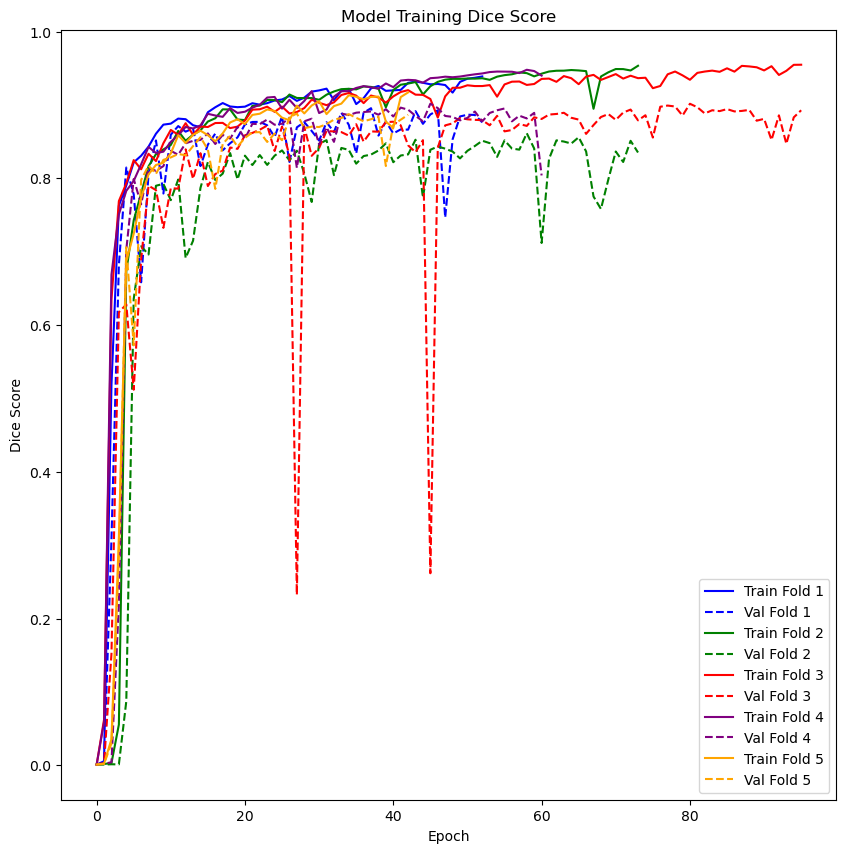

In [20]:
plt.figure(figsize=(10, 10))
colors = ["blue", "green", "red", "purple", "orange"]  # Define colors for the curves
for i, color in enumerate(colors):
    plt.plot(train_dice_list[i], color=color, linestyle="-")
    plt.plot(val_dice_list[i], color=color, linestyle="--")

plt.title("Model Training Dice Score")
plt.ylabel("Dice Score")
plt.xlabel("Epoch")
plt.legend(
    [
        "Train Fold 1",
        "Val Fold 1",
        "Train Fold 2",
        "Val Fold 2",
        "Train Fold 3",
        "Val Fold 3",
        "Train Fold 4",
        "Val Fold 4",
        "Train Fold 5",
        "Val Fold 5"
    ],
    loc="lower right",
)

plt.show()

Write the dataframes to an excel. 

In [21]:
with pd.ExcelWriter(
    r"C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\5_fold_CV_dfs.xlsx"
) as writer:
    for i, df in enumerate(dataframes):
        df.to_excel(writer, sheet_name=f"Fold {i+1}")

Average of 5-fold cross-validation scores. 

In [22]:
dsc_sum = 0
for i, dataframe in enumerate(dataframes):
    dsc_sum += float(dataframe["Dice"].iloc[-2])

print((dsc_sum/len(dataframes)))

0.8800000000000001
